# Chapter 4: Stochastic Simulations

This tutorial will show you how to use GemPy for stochastic simulation of geological models. We will address two approaches for this: (i) Monte Carlo forward simulation, treating input data as uncertain parameter distributions; (ii) Bayesian inference, where we extent the approach with the use of likelihood functions to constrain the stochastic modeling results with additional data.

# Preparation

Import GemPy, matplotlib for plotting, numpy and pandas for data handling.

In [1]:
import sys, os
sys.path.append("../")

# import gempy
import gempy as gp

# inline figures in jupyter notebooks
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pn

## Initialize an example model

First we define the cube size and model extent of our model and initialize the GemPy data object:

In [44]:
# set cube size and model extent
cs = 25
extent = (3000, 3000, 2000)  # (x, y, z)
res = (120, 120, 80)
# initialize geo_data object
geo_data = gp.create_data([0, extent[0],
                           0, extent[1], 
                           0, extent[2]],
                          resolution=[res[0],  # number of voxels
                                      res[1], 
                                      res[2]])

Then we use pandas to load the example data stored as csv files:

In [3]:
geo_data.set_interfaces(pn.read_csv("data/tutorial_ch4_interfaces", index_col="Unnamed: 0"))
geo_data.set_foliations(pn.read_csv("data/tutorial_ch4_foliations", index_col="Unnamed: 0"))

In [35]:
# let's have a look at the upper five interface data entries in the dataframe
geo_data.interfaces.head()

,X,X_std,Y,Y_std,Z,Z_std,annotations,formation,formation number,group_id,order_series,series
0,250,0.0,500,0.0,996,0.0,"${\bf{x}}_{\alpha \,{\bf{1}},0}$",Layer 2,1,l2_a,1,Default serie
1,2500,0.0,2500,0.0,1149,0.0,"${\bf{x}}_{\alpha \,{\bf{1}},1}$",Layer 2,1,l2_b,1,Default serie
2,2250,0.0,1500,0.0,1298,0.0,"${\bf{x}}_{\alpha \,{\bf{1}},2}$",Layer 2,1,l2_b,1,Default serie
3,2750,0.0,500,0.0,995,0.0,"${\bf{x}}_{\alpha \,{\bf{1}},3}$",Layer 2,1,l2_b,1,Default serie
4,500,0.0,2500,0.0,1149,0.0,"${\bf{x}}_{\alpha \,{\bf{1}},4}$",Layer 2,1,l2_a,1,Default serie


In [5]:
# and at all of the foliation data
geo_data.foliations

,G_x,G_y,G_z,X,X_std,Y,Y_std,Z,Z_std,annotations,azimuth,azimuth_std,dip,dip_std,formation,formation number,group_id,order_series,polarity,series
0,-0.517011,-0.000856,0.855978,500.0,NaN,1500.0,NaN,1148.000000,NaN,"${\bf{x}}_{\beta \,{\bf{1}},0}$",269.90514,NaN,31.132011,NaN,Layer 2,1,l2_a,1,1,Default serie
1,0.516174,-0.001427,0.856483,2500.0,NaN,1500.0,NaN,1147.333333,NaN,"${\bf{x}}_{\beta \,{\bf{1}},1}$",90.15845,NaN,31.076066,NaN,Layer 2,1,l2_b,1,1,Default serie


Now let's have a look at the data in the xz-plane:

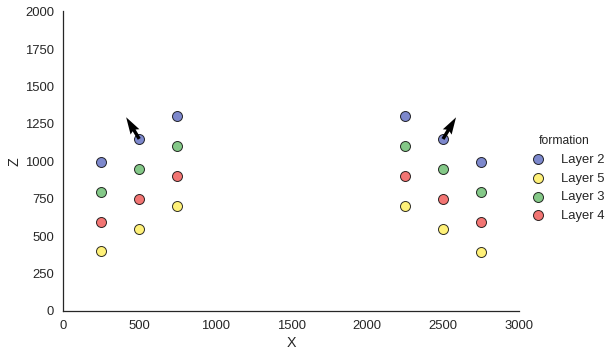

In [6]:
gp.plot_data(geo_data, direction="y")
plt.xlim(0,3000)
plt.ylim(0,2000);

and in the yz-plane:

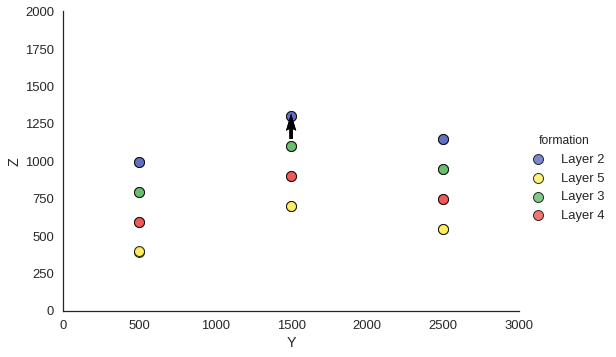

In [7]:
gp.plot_data(geo_data, direction="x")
plt.xlim(0,3000)
plt.ylim(0,2000);

and from above (xy-plane):

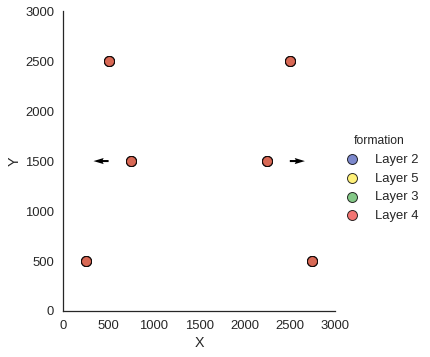

In [8]:
gp.plot_data(geo_data, direction="z")
plt.xlim(0,3000)
plt.ylim(0,3000);

## Compile the interpolator function

Now that we have some input data, the next step is to compile the interpolator function of GemPy with the imported model setup and data:

In [9]:
interp_data = gp.InterpolatorInput(geo_data, u_grade=[0,3])

Level of Optimization:  fast_compile
Device:  cpu
Precision:  float32


Afterwards we can compute the geological model:

In [10]:
solution = gp.compute_model(interp_data)

In [15]:
solution2, potential_field = interp_data.th_fn(*interp_data.get_input_data())

And plot a section:

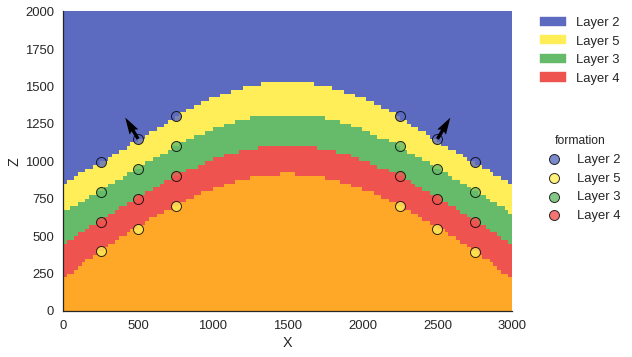

In [16]:
gp.plot_section(geo_data, solution2[0,0,:], 60, plot_data = True)

# Setting up the parameter distributions

For conducting a stochastic simulation of the geological model, we need to consider our input data (dips and layer interfaces) as uncertain - i.e. as distributions.

In [17]:
geo_data.interfaces.head()

,X,X_std,Y,Y_std,Z,Z_std,annotations,formation,formation number,group_id,order_series,series
0,250,0.0,500,0.0,996,0.0,"${\bf{x}}_{\alpha \,{\bf{1}},0}$",Layer 2,1,l2_a,1,Default serie
1,2500,0.0,2500,0.0,1149,0.0,"${\bf{x}}_{\alpha \,{\bf{1}},1}$",Layer 2,1,l2_b,1,Default serie
2,2250,0.0,1500,0.0,1298,0.0,"${\bf{x}}_{\alpha \,{\bf{1}},2}$",Layer 2,1,l2_b,1,Default serie
3,2750,0.0,500,0.0,995,0.0,"${\bf{x}}_{\alpha \,{\bf{1}},3}$",Layer 2,1,l2_b,1,Default serie
4,500,0.0,2500,0.0,1149,0.0,"${\bf{x}}_{\alpha \,{\bf{1}},4}$",Layer 2,1,l2_a,1,Default serie


So let's assume the vertical location of our input data is uncertain, and we want to represent this uncertainty by using a normal distribution. To define a normal distribution, we need a mean and a measure of deviation (e.g. standard deviation). For convenience the input data is already grouped by a "group_id" value, which allows us to collectively modify data that belongs together. In this example we want to treat the vertical position of each layer interface, on each side of the anticline, as uncertain. Therefore, we want to perturbate the respective three points on each side of the anticline collectively.

In [18]:
group_ids = np.unique(geo_data.interfaces["group_id"])
print(group_ids)

['l2_a' 'l2_b' 'l3_a' 'l3_b' 'l4_a' 'l4_b' 'l5_a' 'l5_b']


These are our unique group id's, the number representing the layer, and a/b the side of the anticline.

In [19]:
import pymc

In [20]:
interface_Z_modifier = []
std = 25.

# loop over the unique group id's and create a pymc.Normal distribution for each
for gID in group_ids:
    interface_Z_modifier.append(pymc.Normal(gID, 0, 1./std**2))

List of distributions:

In [21]:
interface_Z_modifier

[<pymc.distributions.new_dist_class.<locals>.new_class 'l2_a' at 0x7fd6e29d2240>,
 <pymc.distributions.new_dist_class.<locals>.new_class 'l2_b' at 0x7fd6e29d22e8>,
 <pymc.distributions.new_dist_class.<locals>.new_class 'l3_a' at 0x7fd6e29d2320>,
 <pymc.distributions.new_dist_class.<locals>.new_class 'l3_b' at 0x7fd6e29d2358>,
 <pymc.distributions.new_dist_class.<locals>.new_class 'l4_a' at 0x7fd6e29d2390>,
 <pymc.distributions.new_dist_class.<locals>.new_class 'l4_b' at 0x7fd6e29d23c8>,
 <pymc.distributions.new_dist_class.<locals>.new_class 'l5_a' at 0x7fd6e29d2400>,
 <pymc.distributions.new_dist_class.<locals>.new_class 'l5_b' at 0x7fd6e29d2438>]

Take a look at one:

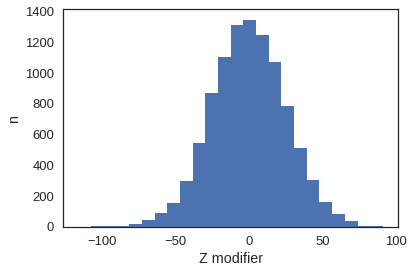

In [22]:
# sample from a distribtion
samples = [interface_Z_modifier[0].rand() for i in range(10000)]
# plot histogram
plt.hist(samples, bins=24);
plt.xlabel("Z modifier")
plt.ylabel("n");

 Now we need to somehow sample from these distribution and put them into GemPy

In [23]:
def rescale(value, rf=interp_data.rescaling_factor):
    return value / rf

# Setting up the pymc-Functions

In [27]:
@pymc.deterministic
def input_data(value = 0, interf_Z_mod = interface_Z_modifier):
    # reset data
    interp_data.geo_data_res = interp_data.rescale_data(geo_data)
    # iterate over all group id's in list
    for i, g_id in enumerate(group_ids):
        f = interp_data.geo_data_res.interfaces["group_id"] == g_id  # filter
        # iterate over every interface with the respective group id
        for index, row in interp_data.geo_data_res.interfaces[f].iterrows():
            val = row["Z"] + rescale(float(interface_Z_modifier[i]))
            # modify value
            interp_data.geo_data_res.interfaces.set_value(index, "Z", val)
        # do the same for foliations
        f = interp_data.geo_data_res.foliations["group_id"] == g_id
        for index, row in interp_data.geo_data_res.foliations[f].iterrows():
            val = row["Z"] + rescale(float(interface_Z_modifier[i]))
            # modify value
            interp_data.geo_data_res.foliations.set_value(index, "Z", val)
    # then return the input data to be input into the modeling function
    return interp_data.get_input_data()

In [31]:
@pymc.deterministic(trace=True)
def gempy_model(value=0,
                input_data=input_data, verbose=False):
    
    try:
        # try to compute model
        sol, pot = interp_data.th_fn(*input_data)
        
        if verbose:
            print(sol)
            print(np.shape(sol))
            plt.imshow(sol[0,0,:].reshape(res[0], res[1], res[2])[:,40,:].T,
                       origin="lower", cmap="YlOrRd")
        
        return sol
    except:
        # if it fails (e.g. some input data combinations could lead to 
        # a singular matrix and thus break the chain) return an empty model
        # with same dimensions (just zeros)
        return np.zeros_like(solution)

In [32]:
params = [input_data, gempy_model, *interface_Z_modifier]
model = pymc.Model(params)

In [33]:
iterations = 10

In [34]:
%matplotlib inline
RUN = pymc.MCMC(model)
RUN.sample(iter=iterations)

 [------------------110%-------------------] 11 of 10 complete in 180.8 sec

# Analyze the Results

In [41]:
gp.colors.cmap

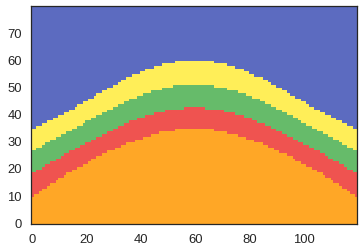

In [49]:
sol = RUN.trace("gempy_model", chain=-1)[1]
plt.imshow(sol[0,0,:].reshape(res[0], res[1], res[2])[:,40,:].T, 
           origin="lower", cmap=gp.colors.cmap, norm=gp.colors.norm)

In [43]:
np.shape(RUN.trace("gempy_model", chain=-1)[1])

(1, 3, 1152000)